
背景

NASA的预测卓越中心（Prognostic Center of Excellence）建立了一个数据集仓库，用于为预测与预测性维护相关的算法提供基准测试。

其中一个数据集来自涡扇发动机的仿真模型 C-MAPSS（Commercial Modular Aero Propulsion System Simulation，商业模块化航空推进系统仿真）。C-MAPSS 是一个用于生成模拟涡扇发动机的健康状态、控制参数和引擎参数的工具。通过一个自定义代码封装器，在传感器时间序列数据中注入了合成故障和持续退化趋势。

该数据集的一些特征如下：

数据来自高保真度的涡扇发动机仿真，但能够很好地模拟实际发动机的传感器数值；
数据中加入了合成噪声，以模拟真实世界中的情况；
故障效应受操作工况的掩盖，这在大多数真实系统中也是常见现象


In [1]:
import io
import os
import json
import zipfile
import urllib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime


定义数据集的列

在原始数据集中，每一行数据中都包含空格分开的各个列。其含义如下：

id：        发动机编号
cycle：     发动机运行次数
setting1：  参数设置1
...
s1:         传感器1的数据
...

每一行代表每一次运行的数据。id和cycle表示的是第几号发动机第几次的运行

In [2]:
data_folder = 'CMAPSSData'
columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14','s15', 's16', 's17', 's18', 's19', 's20', 's21']


从数据集的目录下加载数据文件

数据集目录下文件的特点：
train_FD001~4 : 4个训练用数据文件。包含每个发动机运行到坏的所有次数的数据
test_FD001~4 ： 4个测试用数据文件。包含每个发动机运行到当前次数的数据
RUL_FD001~4 :   4个标签数据。对应每个test文件中的当前RUL

下面代码的数据处理说明：

从文件中读取训练数据

每个文件中读取的行列数据放入pandas数据集。给数据集加上列头，然后把每个setting数据和传感器数据进行归一化处理，
也就是：归一化的列值 =（列值-列最小值）/（列最大值-列最小值）

把数据按id列进行分组group，即按不同发动机分组。分组的cycle取最大值，也就是该发动机最大的运行次数。
最大值-每行cycle值 = 每行RUL值。计算出RUL后就drop掉max值。
这样训练数据每一行就加入了标签数据RUL列

从4个文件中读取的数据集全部加到train_df的数据里


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.999926,0.997625,1.0,1.357405e-08,0.130347,0.272082,0.212586,9.337067e-08,...,0.993111,0.550773,0.400540,0.0001,0.288660,0.627907,1.0,0.015473,0.015881,320
1,1,2,0.476147,0.831592,1.0,6.269852e-01,0.647971,0.634407,0.511781,5.079366e-01,...,0.992395,0.481761,0.351346,0.0001,0.608247,0.864693,1.0,0.477968,0.481487,319
2,1,3,0.999900,0.998694,1.0,1.357405e-08,0.123646,0.271245,0.222481,9.337067e-08,...,0.993056,0.531031,0.423788,0.0001,0.278351,0.627907,1.0,0.010764,0.018932,318


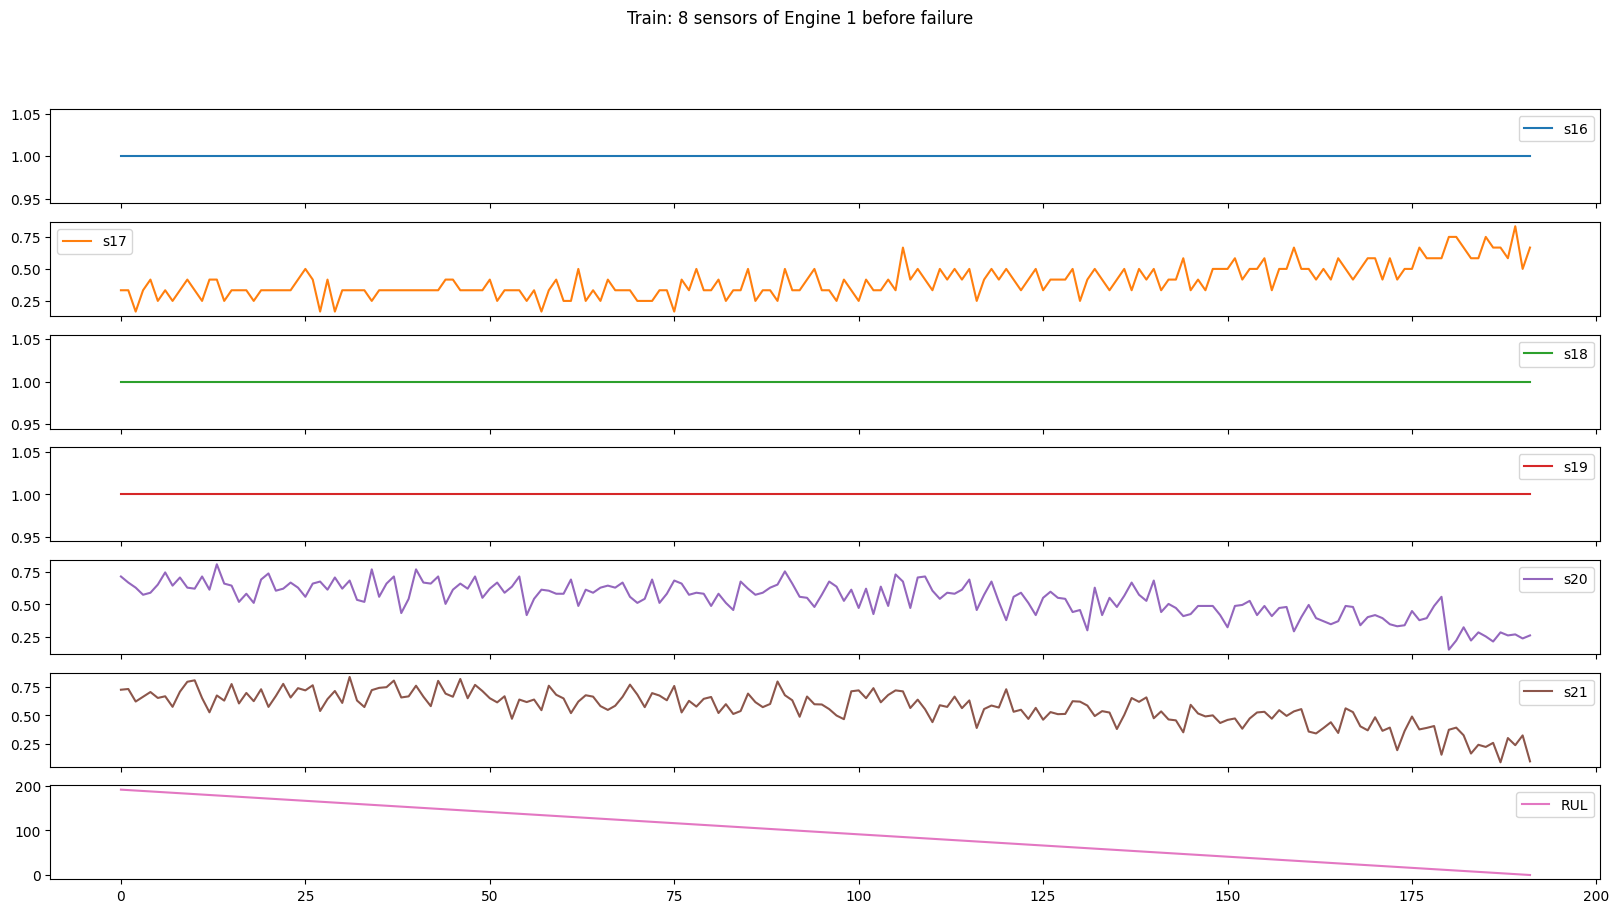

In [3]:
train_df = []
train_df_raw = []

eps = 0.000001 # for floating point issues during normalization 
for i in range(1,5):
    df = pd.read_csv('CMAPSSData/train_FD{:03d}.txt'.format(i), sep='\s+', header=None)
    #df = pd.read_csv('CMAPSSData/train_FD{:03d}.txt'.format(i), delim_whitespace=True, header=None)
    #df.drop(df.columns[[26, 27]], axis=1, inplace=True)
    df.columns = columns
    df_raw = df.copy()

    df[columns[2:]]=(df[columns[2:]]-df[columns[2:]].min()+eps)/(df[columns[2:]].max()-df[columns[2:]].min()+eps)
    train_df.append(df)
    train_df_raw.append(df_raw)

# compute RUL (remaining useful life)
for i, df in enumerate(train_df):
    rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop('max', axis=1, inplace=True)
    train_df[i]=df

o = train_df[0][columns[20:]+['RUL']][train_df[0]['id'] == 1].plot(subplots=True, sharex=True, figsize=(20,10), title="Train: 8 sensors of Engine 1 before failure")
df.head(3)

原始数据和归一化的数据的比较

array([<Axes: >, <Axes: >], dtype=object)

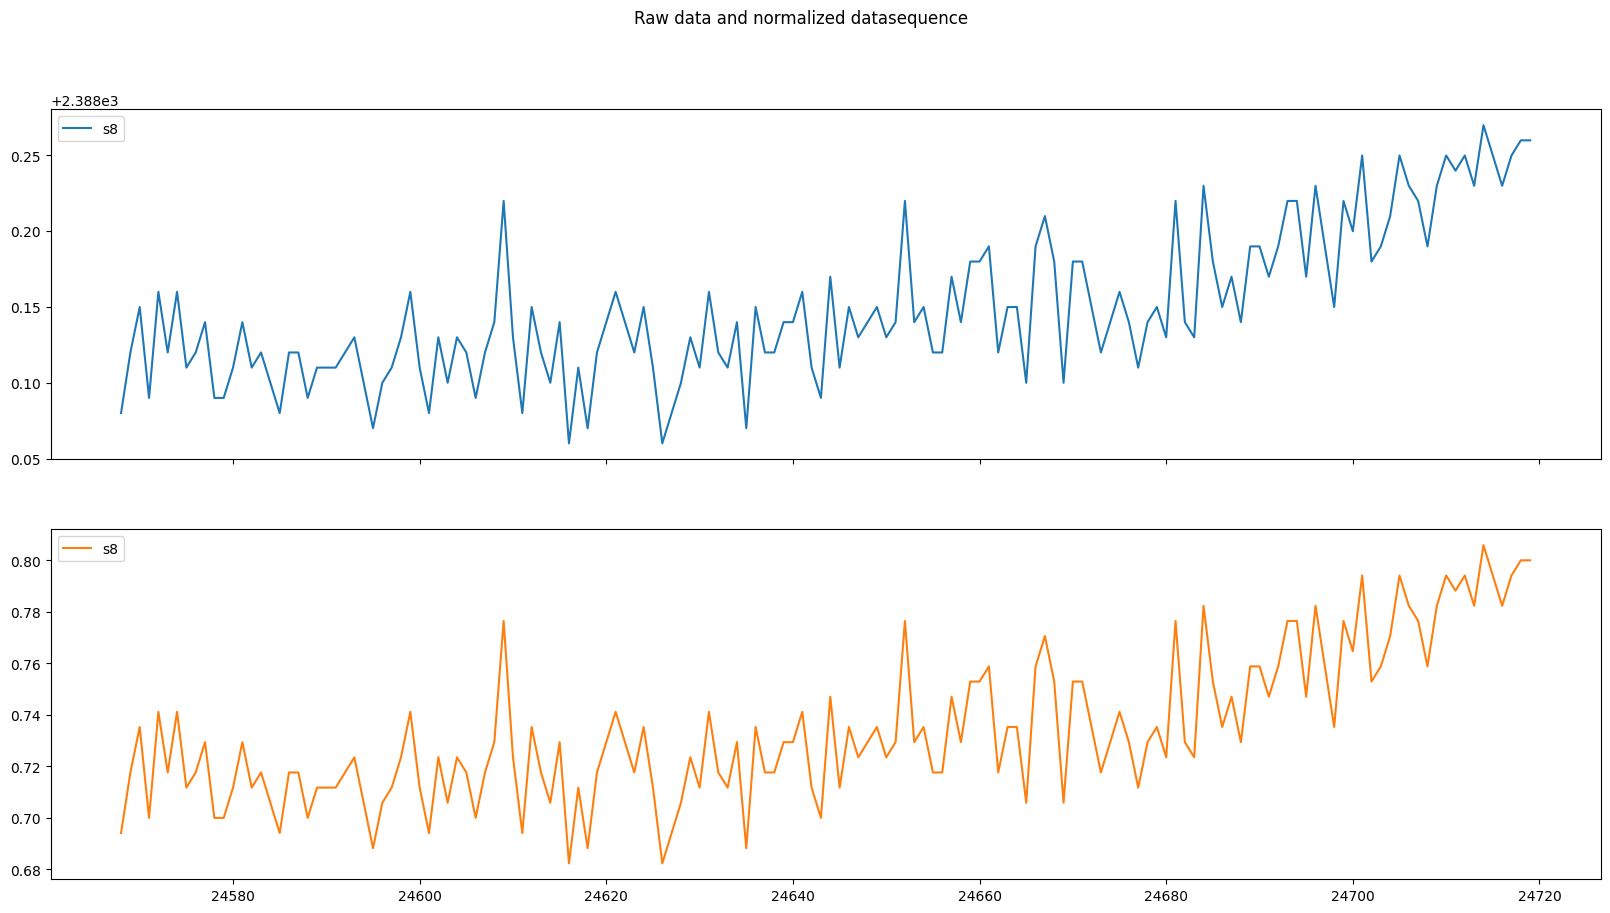

In [4]:
FILE=2          #数据文件编号，从0到3
COLUMN=12        #数据列号，从2到24
ENGINE_ID=100   #发动机编号，从1到每个文件最大的id


pd.concat(
    [train_df_raw[FILE][columns[COLUMN]][train_df_raw[FILE]['id'] == ENGINE_ID], 
     train_df[FILE][columns[COLUMN]][train_df[FILE]['id'] == ENGINE_ID]], 
     axis=1).plot(
         subplots=True, 
         sharex=True, 
         figsize=(20,10), 
         title="Raw data and normalized datasequence")


#train_df_raw[FILE][columns[COLUMN]][train_df_raw[0]['id'] == ENGINE_ID].plot(subplots=False, sharex=True, figsize=(20,10), title="Raw data sequence")
#train_df[FILE][columns[COLUMN]][train_df[0]['id'] == ENGINE_ID].plot(subplots=False, sharex=True, figsize=(20,10), title="Nomalized data sequence")

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.476271,0.831354,1.000000e+00,6.269852e-01,0.656561,0.654027,0.501557,5.079366e-01,...,0.996016,0.574006,0.362211,0.0001,0.631579,8.646934e-01,1.000000e+00,0.478320,0.483780,251
1,1,2,0.595087,0.736342,2.500000e-08,2.380888e-01,0.007372,0.041486,0.016265,2.931840e-01,...,0.000968,0.039366,0.945325,0.0001,0.042105,2.114165e-09,6.635700e-08,0.141260,0.137380,250
2,1,3,0.999810,1.000000,1.000000e+00,1.357405e-08,0.127258,0.270191,0.200168,9.337067e-08,...,0.996487,0.637839,0.423747,0.0001,0.273684,6.279070e-01,1.000000e+00,0.006775,0.016466,249


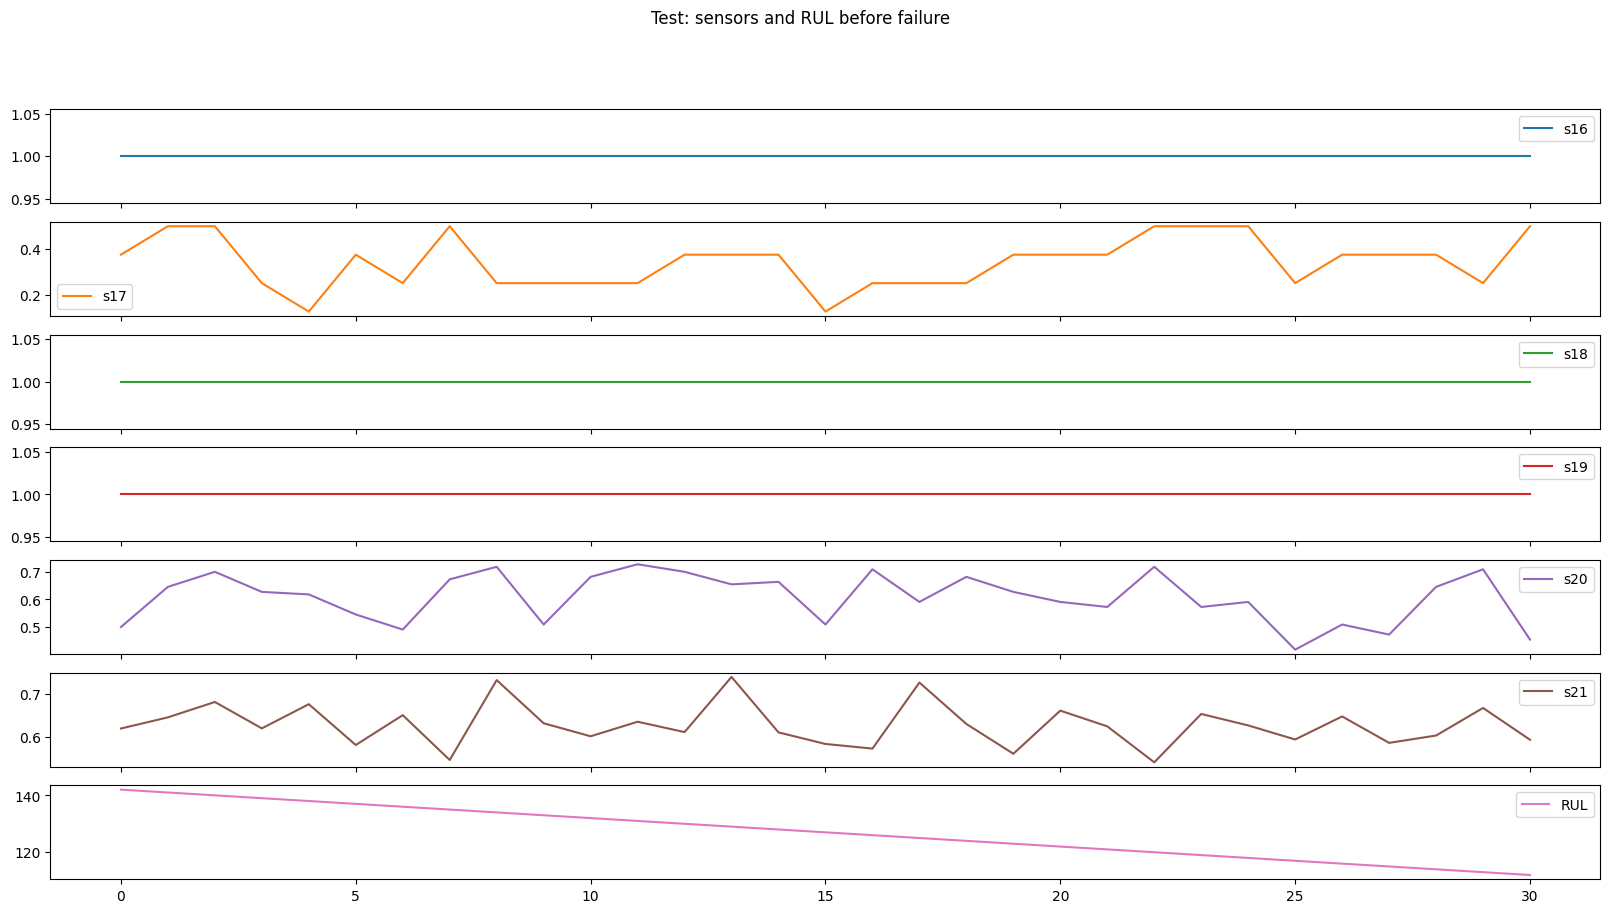

In [5]:
test_df = []
for i in range(1,5):
    # Load time series
    df = pd.read_csv('CMAPSSData/test_FD{:03d}.txt'.format(i), sep='\s+', header=None)

    # Load the RUL values
    df_rul = pd.read_csv('CMAPSSData/RUL_FD{:03d}.txt'.format(i), sep='\s+', header=None)    
    df_rul.index += 1

    # Merge RUL and timeseries and compute RUL per timestamp
    df = df.merge(df_rul, left_on=df.columns[0], right_index=True, how='left')

    df.drop(df.columns[0], axis=1, inplace=True)
    df.columns = columns + ['RUL_end']
    rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    df = df.merge(rul, on=['id'], how='left') # We get the number of cycles per series
    df['RUL'] = df['max'] + df['RUL_end'] - df['cycle'] # The RUL is the number of cycles per series + RUL - how many cycles have already ran
    df.drop(['max','RUL_end'], axis=1, inplace=True)
    
    # Normalize
    df[columns[2:]]=(df[columns[2:]]-df[columns[2:]].min()+eps)/(df[columns[2:]].max()-df[columns[2:]].min()+eps)
    test_df.append(df)


t = test_df[0][columns[20:]+['RUL']][test_df[0]['id'] == 1].plot(subplots=True, sharex=True, figsize=(20,10), title="Test: sensors and RUL before failure")
df.head(3)

In [6]:
import torch
from torch.nn.utils.rnn import pad_sequence

# 假设你只取 sensor 和 setting 数据，不包括 'id', 'cycle', 'RUL'
feature_cols = columns[2:]  # ['setting1', ..., 's21']
target_col = 'RUL'

def df_to_sequence_list(df, feature_cols, target_col=None):
    """
    将 dataframe 转为 [batch, seq_len, feature] 形式的列表
    返回两个 list：features, labels
    """
    sequences = []
    labels = []

    for _, group in df.groupby('id'):
        feature_tensor = torch.tensor(group[feature_cols].values, dtype=torch.float32)
        sequences.append(feature_tensor)

        if target_col is not None:
            label_tensor = torch.tensor(group[target_col].values, dtype=torch.float32)
            labels.append(label_tensor)

    return sequences, labels

In [7]:
# 对 train_df 处理
train_sequences, train_labels = [], []
for df in train_df:
    seqs, lbls = df_to_sequence_list(df, feature_cols, target_col)
    train_sequences.extend(seqs)
    train_labels.extend(lbls)

# 对 test_df 处理
test_sequences, test_labels = [], []
for df in test_df:
    seqs, lbls = df_to_sequence_list(df, feature_cols, target_col)
    test_sequences.extend(seqs)
    test_labels.extend(lbls)

In [8]:
padded_train_sequences = pad_sequence(train_sequences, batch_first=True)  # [batch, max_seq_len, feature]
padded_train_labels = pad_sequence(train_labels, batch_first=True)        # [batch, max_seq_len]

In [9]:
print(len(train_sequences))
print(len(train_labels))
print(train_sequences[0].shape)
print(train_labels[0].shape)

batch = 10

709
709
torch.Size([192, 24])
torch.Size([192])


<Axes: title={'center': 'Train: RUL before failure'}>

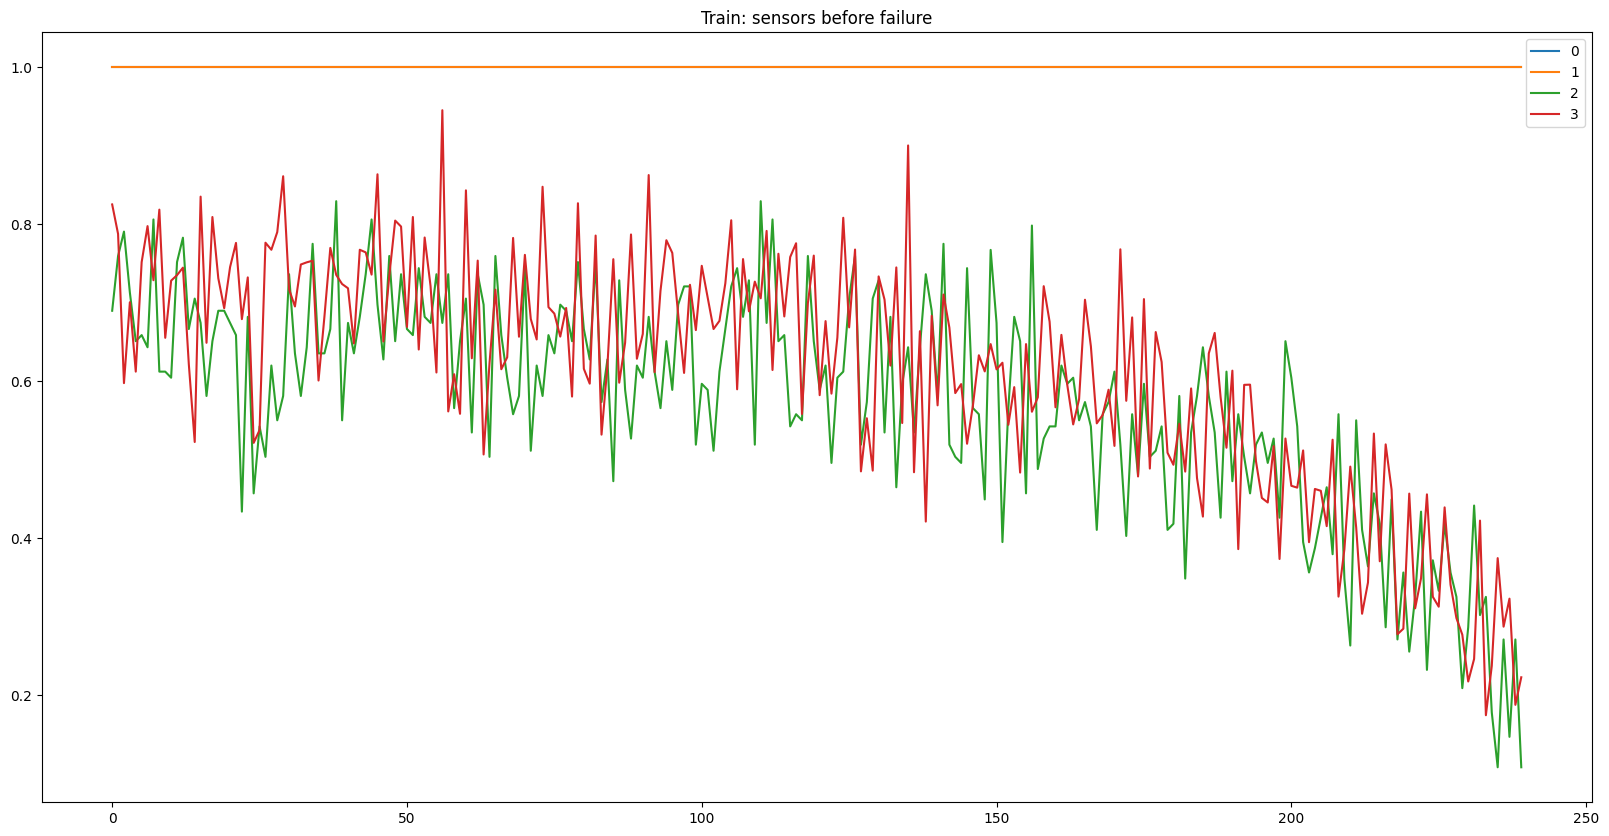

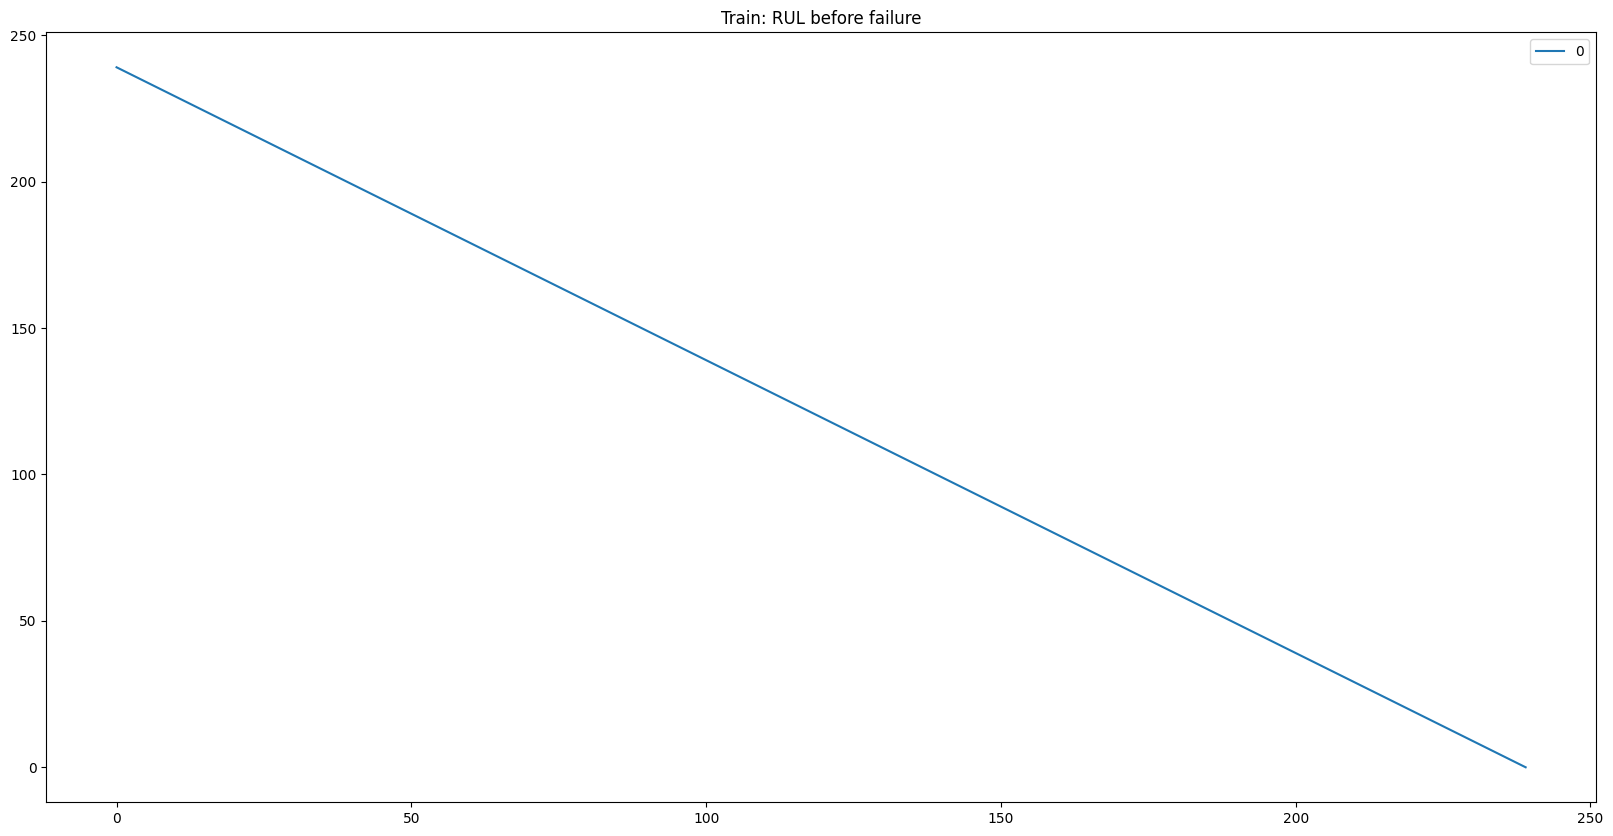

In [10]:
a = train_sequences[batch][:,20:].numpy()  # 形状 (192, 2)
p = pd.DataFrame(a)
p.plot( subplots=False, sharex=True, figsize=(20,10), title="Train: sensors before failure")

a = train_labels[batch][:].numpy()  # 形状 (192, 2)
p = pd.DataFrame(a)
p.plot( subplots=False, sharex=True, figsize=(20,10), title="Train: RUL before failure")



torch.Size([709, 543, 24])
torch.Size([709, 543])


<Axes: title={'center': 'Train: RUL before failure'}>

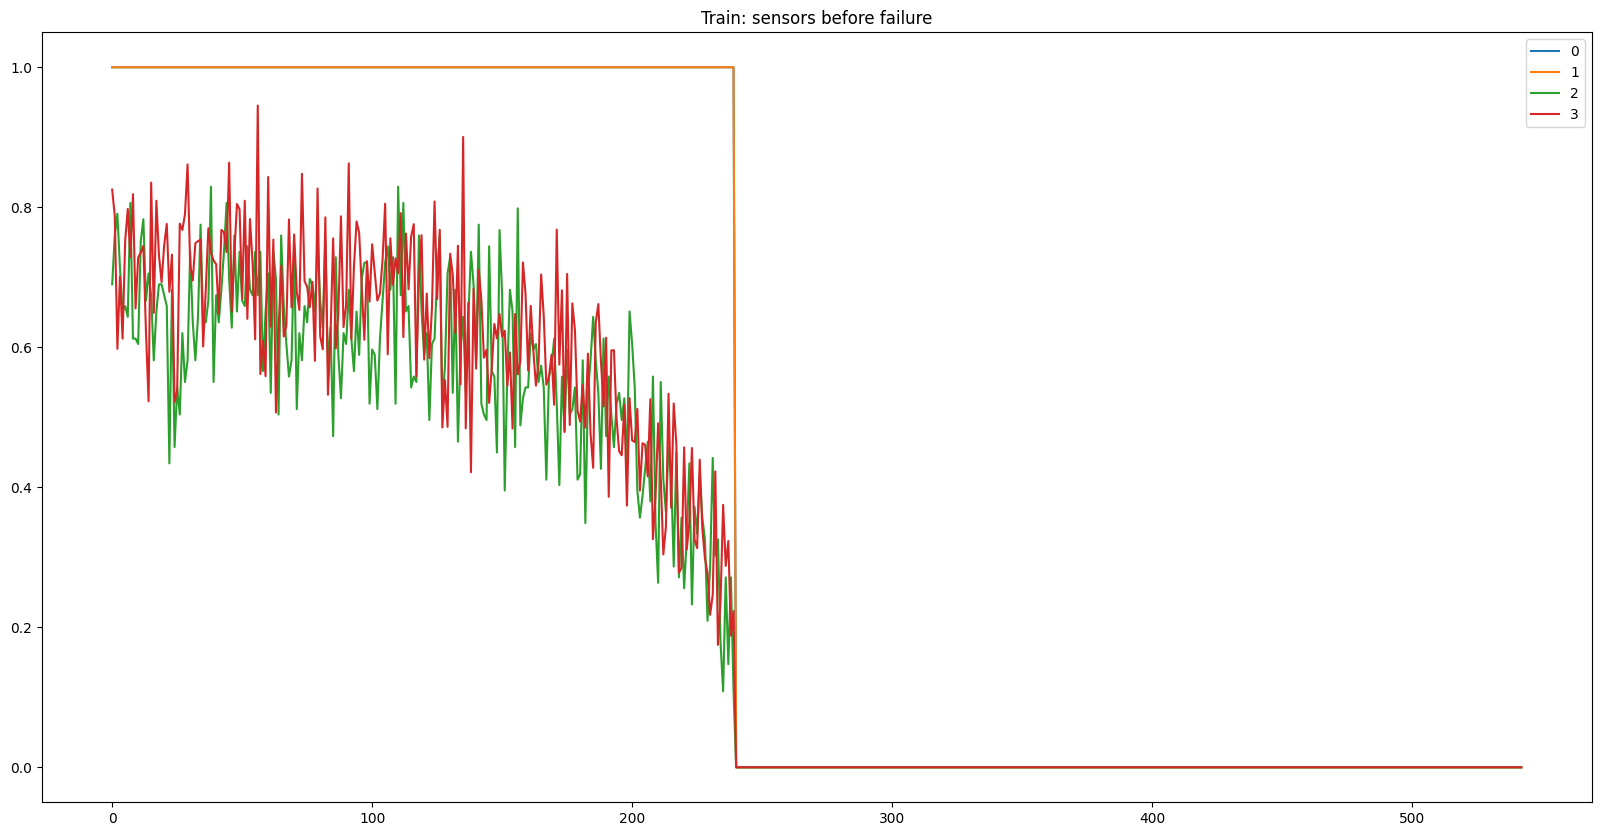

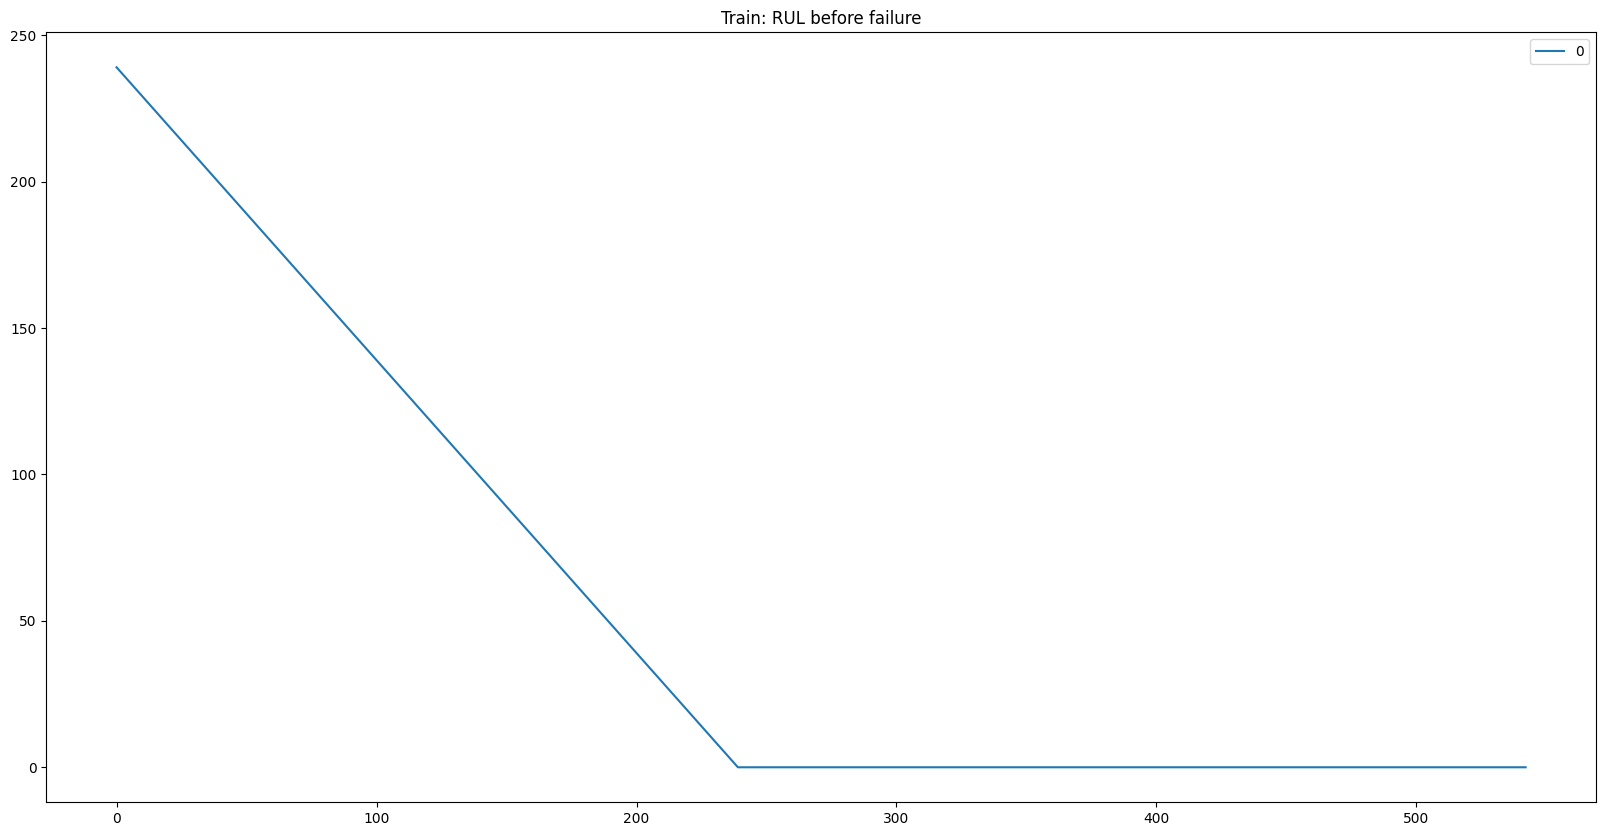

In [11]:
print(padded_train_sequences.shape)
print(padded_train_labels.shape)

a = padded_train_sequences[batch, :,20:].numpy()
p = pd.DataFrame(a)
p.plot( subplots=False, sharex=True, figsize=(20,10), title="Train: sensors before failure")

a = padded_train_labels[batch, :].numpy()
p = pd.DataFrame(a)
p.plot( subplots=False, sharex=True, figsize=(20,10), title="Train: RUL before failure")


In [12]:
train_lengths = torch.tensor([len(seq) for seq in train_sequences])  # [batch]
test_lengths = torch.tensor([len(seq) for seq in test_sequences])    # [batch]


In [13]:
train_lengths[batch]

tensor(240)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ConvLSTMRULPredictor(nn.Module):
    def __init__(self, input_dim, conv_channels=64, lstm_hidden_dim=128, num_layers=2, dropout=0.2):
        super(ConvLSTMRULPredictor, self).__init__()
        
        # 第一层卷积
        self.conv1 = nn.Conv1d(input_dim, conv_channels, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(conv_channels)
        
        # 第二层卷积
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(conv_channels)
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=lstm_hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 输出层
        self.fc = nn.Linear(lstm_hidden_dim*2, 1)
        
    def forward(self, x, lengths):
        # x shape: [batch, seq_len, features]
        batch_size = x.size(0)
        
        # 转置卷积维度 [batch, features, seq_len]
        x = x.transpose(1, 2)
        
        # 第一层卷积 + ReLU + BatchNorm
        x = F.relu(self.bn1(self.conv1(x)))
        
        # 第二层卷积 + ReLU + BatchNorm
        x = F.relu(self.bn2(self.conv2(x)))
        
        # 转回LSTM需要的维度 [batch, seq_len, features]
        x = x.transpose(1, 2)
        
        # 打包序列以处理变长序列
        packed_input = pack_padded_sequence(
            x, 
            lengths.cpu(), 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # LSTM处理
        packed_output, _ = self.lstm(packed_input)
        
        # 解包序列
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # 输出层
        out = self.fc(output)
        
        return out.squeeze(-1)  # [batch, seq_len]


In [15]:
# 模型参数
input_dim = padded_train_sequences.shape[2]  # 特征维度

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvLSTMRULPredictor(
    input_dim=input_dim,
    conv_channels=64,
    lstm_hidden_dim=256,
    num_layers=2,
    dropout=0.2
).to(device)



# 打印模型结构
print(model)

# 定义损失函数和优化器
#criterion = nn.MSELoss()  # 回归问题使用MSE损失
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_result_array=[]

ConvLSTMRULPredictor(
  (conv1): Conv1d(24, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


In [16]:
# 训练函数
def train_model(model, train_sequences, train_labels, train_lengths, num_epochs=50, batch_size=32):
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        
        # 随机打乱数据
        indices = torch.randperm(len(train_sequences))
        
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            
            batch_sequences = train_sequences[batch_indices].to(device)
            batch_labels = train_labels[batch_indices].to(device)
            batch_lengths = train_lengths[batch_indices].to(device)
            
            # 前向传播
            outputs = model(batch_sequences, batch_lengths)
            
            # 计算RMSE损失（逐样本计算后取平均）
            batch_loss = 0
            for j in range(len(batch_lengths)):
                seq_len = batch_lengths[j]
                # 1. 计算每个时间步的平方误差
                squared_error = (outputs[j, :seq_len] - batch_labels[j, :seq_len]) ** 2
                # 2. 计算单个样本的MSE，再开平方得到RMSE
                rmse = torch.sqrt(torch.mean(squared_error))
                batch_loss += rmse
            
            # 当前批次所有样本的平均RMSE
            batch_loss /= len(batch_lengths)

            # 反向传播和优化
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            total_loss += batch_loss.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches

        loss_result_array.append(avg_loss)
        #print(f'Epoch [{epoch+1}/{num_epochs}], RMSE Loss: {avg_loss:.4f}')
        print(f'[{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}] Epoch [{epoch+1}/{num_epochs}], RMSE Loss: {avg_loss:.4f}')


In [17]:
# 开始训练
EPOCHS = 100

train_model(
    model, 
    padded_train_sequences, 
    padded_train_labels, 
    train_lengths, 
    num_epochs=EPOCHS, 
    batch_size=32
)

[2025-04-20 01:09:26] Epoch [1/100], RMSE Loss: 119.0819
[2025-04-20 01:09:27] Epoch [2/100], RMSE Loss: 107.0599
[2025-04-20 01:09:28] Epoch [3/100], RMSE Loss: 97.5730
[2025-04-20 01:09:29] Epoch [4/100], RMSE Loss: 90.3406
[2025-04-20 01:09:31] Epoch [5/100], RMSE Loss: 82.9424
[2025-04-20 01:09:32] Epoch [6/100], RMSE Loss: 75.4674
[2025-04-20 01:09:33] Epoch [7/100], RMSE Loss: 67.1730
[2025-04-20 01:09:34] Epoch [8/100], RMSE Loss: 62.2350
[2025-04-20 01:09:35] Epoch [9/100], RMSE Loss: 54.1505
[2025-04-20 01:09:36] Epoch [10/100], RMSE Loss: 47.2371
[2025-04-20 01:09:37] Epoch [11/100], RMSE Loss: 43.2091
[2025-04-20 01:09:38] Epoch [12/100], RMSE Loss: 38.5009
[2025-04-20 01:09:39] Epoch [13/100], RMSE Loss: 33.7688
[2025-04-20 01:09:40] Epoch [14/100], RMSE Loss: 30.3605
[2025-04-20 01:09:41] Epoch [15/100], RMSE Loss: 27.8163
[2025-04-20 01:09:42] Epoch [16/100], RMSE Loss: 24.4692
[2025-04-20 01:09:43] Epoch [17/100], RMSE Loss: 22.3303
[2025-04-20 01:09:44] Epoch [18/100], 

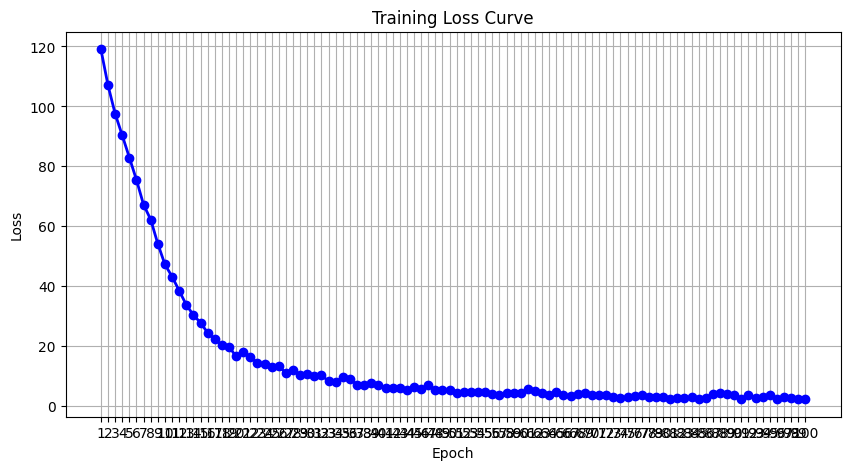

In [18]:
# 训练完成后绘制loss曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), loss_result_array, 'b-o', linewidth=2)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, EPOCHS+1))
plt.show()